# 01c - Entrenamiento Binario en Keras

## Objetivo

El objetivo de este notebook es obtener un modelo de clasificación binaria ('Apto' / 'Noapto') en formato Keras, siguiendo el mismo tratamiento del dataset realizado previamente en PyTorch.

Utilizaremos los archivos procesados:
- Imágenes en carpetas `Apto` y `Noapto` dentro de `binario/`
- CSVs de división `train.csv`, `val.csv` y `test.csv` dentro de `binario_split/`

El flujo de trabajo seguirá:
1. Carga de datos desde CSVs.
2. Creación de datasets de TensorFlow.
3. Selección de backbones preentrenados.
4. Entrenamiento de modelos con fine-tuning.
5. Selección del mejor modelo.
6. Guardado en formato `.keras` para despliegue.

---


In [1]:
# Importar librerías principales
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Definir rutas de los CSVs
train_csv_path = '../data/binario_split/train.csv'
val_csv_path = '../data/binario_split/val.csv'
test_csv_path = '../data/binario_split/test.csv'

# Leer los CSVs
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Mostrar una muestra para verificar
print("Train dataset sample:")
display(train_df.head())

print("\nValidation dataset sample:")
display(val_df.head())

print("\nTest dataset sample:")
display(test_df.head())


Train dataset sample:


,filepath,label
0,..\data\binario\Apto\Atento_01610.jpg,Apto
1,..\data\binario\NoApto\Eyes_Closed_01002.jpg,NoApto
2,..\data\binario\NoApto\Bostezo_03464.jpg,NoApto
3,..\data\binario\NoApto\Bostezo_01360.jpg,NoApto
4,..\data\binario\NoApto\Bostezo_03089.jpg,NoApto



Validation dataset sample:


,filepath,label
0,..\data\binario\NoApto\Eyes_Closed_00277.jpg,NoApto
1,..\data\binario\NoApto\Eyes_Closed_00076.jpg,NoApto
2,..\data\binario\Apto\Atento_04098.jpg,Apto
3,..\data\binario\NoApto\Bostezo_00601.jpg,NoApto
4,..\data\binario\NoApto\Bostezo_02590.jpg,NoApto



Test dataset sample:


,filepath,label
0,..\data\binario\NoApto\Eyes_Closed_00089.jpg,NoApto
1,..\data\binario\NoApto\Bostezo_02585.jpg,NoApto
2,..\data\binario\Apto\Atento_01059.jpg,Apto
3,..\data\binario\Apto\Atento_01155.jpg,Apto
4,..\data\binario\Apto\Atento_02687.jpg,Apto


## Creación de Datasets TensorFlow

En este apartado transformaremos los DataFrames de Pandas (`train_df`, `val_df`, `test_df`) en datasets nativos de TensorFlow (`tf.data.Dataset`).

El flujo de trabajo será:
1. Definir una función que cargue una imagen desde el disco y le asocie su etiqueta.
2. Aplicar normalización de píxeles [0, 1].
3. Redimensionar todas las imágenes a (224, 224) para compatibilidad con los modelos preentrenados.
4. Crear datasets de entrenamiento, validación y prueba.

Esto nos permitirá utilizar los datasets de forma eficiente durante el entrenamiento.


In [2]:
# Definir tamaño de las imágenes y batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Función para procesar una imagen
def process_image(file_path, label):
    # Leer la imagen
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Redimensionar
    img = tf.image.resize(img, IMG_SIZE)
    # Normalizar
    img = img / 255.0
    return img, label

# Función para convertir texto de etiquetas a números
def encode_label(label):
    # Etiquetas: Apto = 0, NoApto = 1
    return tf.cast(tf.equal(label, 'NoApto'), tf.int32)

# Función para crear tf.data.Dataset a partir de un dataframe
def df_to_dataset(df, shuffle=True, batch_size=BATCH_SIZE):
    file_paths = df['filepath'].apply(lambda x: x.replace('\\', '/')).values
    labels = df['label'].values

    # Convertir a tensor
    file_paths = tf.constant(file_paths)
    labels = tf.constant(labels)

    # Crear dataset
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # Codificar las etiquetas
    ds = ds.map(lambda x, y: (x, encode_label(y)), num_parallel_calls=tf.data.AUTOTUNE)

    # Cargar las imágenes
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))

    return ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Crear datasets
train_ds = df_to_dataset(train_df, shuffle=True)
val_ds = df_to_dataset(val_df, shuffle=False)
test_ds = df_to_dataset(test_df, shuffle=False)

print("Datasets de TensorFlow creados correctamente.")


Datasets de TensorFlow creados correctamente.


## Visualización de Ejemplos del Dataset

Antes de comenzar el entrenamiento, es importante verificar que las imágenes y las etiquetas han sido cargadas correctamente.

En esta sección:
- Mostraremos una pequeña muestra de imágenes del dataset de entrenamiento.
- Confirmaremos que la asignación de etiquetas (Apto/NoApto) es correcta.


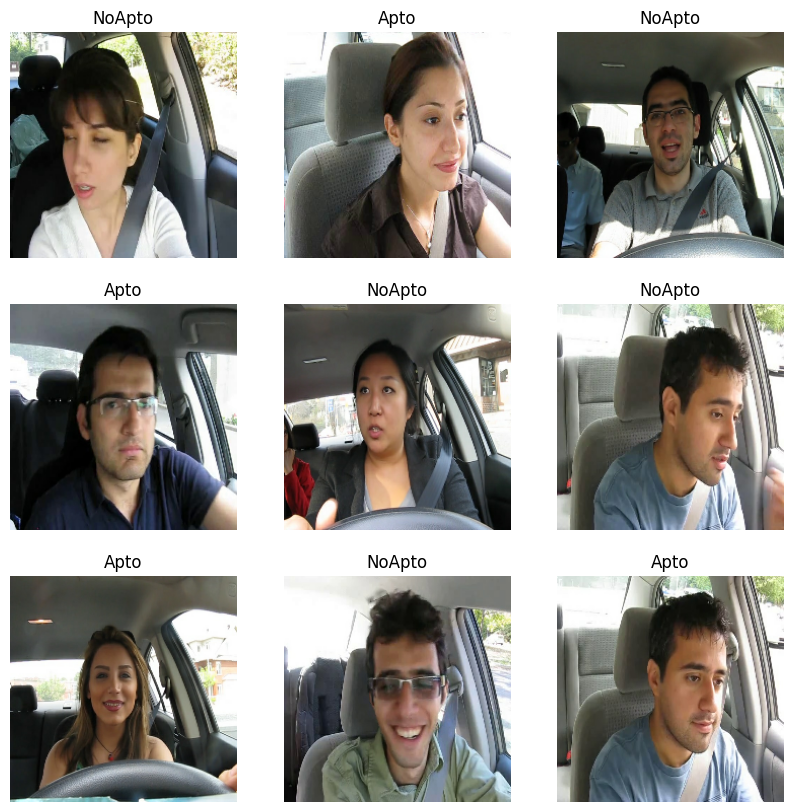

In [3]:
# Función para mostrar un batch de imágenes
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(9):
        ax = plt.subplot(3, 3, n+1)
        plt.imshow(image_batch[n])
        label = 'NoApto' if label_batch[n].numpy() == 1 else 'Apto'
        plt.title(label)
        plt.axis('off')

# Obtener un batch del train_ds
image_batch, label_batch = next(iter(train_ds))

# Mostrar las imágenes
show_batch(image_batch, label_batch)


## Selector de Backbones en Keras

Con el objetivo de encontrar el mejor modelo para nuestro caso de clasificación binaria ('Apto' / 'NoApto'), implementaremos un selector de backbones basado en Transfer Learning.

Los modelos que probaremos serán:
- EfficientNetB0
- MobileNetV2
- DenseNet121
- ResNet50
- Xception
- InceptionV3

El flujo de trabajo será:
1. Utilizar el modelo preentrenado en ImageNet como extractor de características.
2. Congelar las capas del backbone inicialmente.
3. Añadir una nueva "cabeza" de clasificación (GlobalAveragePooling + Dense).
4. Entrenar solo la cabeza durante unas pocas épocas para evaluación rápida.
5. Guardar las métricas de validación para cada modelo.
6. Elegir el mejor backbone para entrenamiento final (fine-tuning).

Esto nos permitirá seleccionar el modelo más adecuado de forma rápida y eficiente.


In [4]:
from tensorflow.keras import layers, models, applications

# Diccionario de modelos preentrenados
backbone_dict = {
    'EfficientNetB0': applications.EfficientNetB0,
    'MobileNetV2': applications.MobileNetV2,
    'DenseNet121': applications.DenseNet121,
    'ResNet50': applications.ResNet50,
    'Xception': applications.Xception,
    'InceptionV3': applications.InceptionV3,
}

# Función para crear un modelo completo dado un backbone
def create_model(backbone_name, input_shape=(224,224,3)):
    print(f"Creando modelo con backbone: {backbone_name}")
    
    # Cargar el modelo base sin la parte final (sin incluir la capa de clasificación)
    base_model = backbone_dict[backbone_name](
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False  # Congelamos el backbone inicialmente

    # Añadimos la cabeza de clasificación
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)  # Para evitar overfitting
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Salida binaria

    model = models.Model(inputs, outputs)
    
    # Compilamos el modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


## Entrenamiento rápido de los diferentes backbones

En esta sección:
- Entrenaremos cada modelo seleccionado durante un pequeño número de épocas (5 epochs).
- El objetivo es comparar rápidamente su rendimiento inicial sin necesidad de entrenamientos largos.
- Las capas del backbone estarán congeladas (solo entrenamos la "cabeza").
- Se guardarán los resultados de validación (accuracy y loss) de cada modelo.

Esto nos permitirá seleccionar el mejor backbone para realizar el entrenamiento completo posterior (fine-tuning).


In [6]:
import pandas as pd

# Definir el número de épocas rápidas para evaluar
EPOCHS_RAPID = 5

# Crear un diccionario para guardar los resultados
results = {}

# Recorrer cada backbone
for backbone_name in backbone_dict.keys():
    print(f"\nEntrenando modelo con backbone: {backbone_name}")
    print("-" * 50)
    
    # Crear el modelo
    model = create_model(backbone_name)
    
    # Entrenar el modelo
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_RAPID,
        verbose=1
    )
    
    # Guardar resultados finales de validación
    val_accuracy = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    results[backbone_name] = {
        'val_accuracy': val_accuracy,
        'val_loss': val_loss
    }

# Mostrar resultados ordenados por mejor accuracy
print("\nResultados de los backbones:")
sorted_results = sorted(results.items(), key=lambda x: x[1]['val_accuracy'], reverse=True)
for backbone, metrics in sorted_results:
    print(f"{backbone}: Accuracy = {metrics['val_accuracy']:.4f}, Loss = {metrics['val_loss']:.4f}")

# -------------------------
# Guardar resultados en un CSV
# -------------------------

# Convertir a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.reset_index().rename(columns={'index': 'backbone'})

# Crear carpeta si no existe
os.makedirs('../models', exist_ok=True)

# Guardar
results_df.to_csv('../models/resumen_backbones.csv', index=False)
print("\nResultados guardados en '../models/resumen_backbones.csv'")



Entrenando modelo con backbone: EfficientNetB0
--------------------------------------------------
Creando modelo con backbone: EfficientNetB0
Epoch 1/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 75s 298ms/step - accuracy: 0.5095 - loss: 0.7028 - val_accuracy: 0.4934 - val_loss: 0.6971
Epoch 2/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 64s 282ms/step - accuracy: 0.4855 - loss: 0.7000 - val_accuracy: 0.4934 - val_loss: 0.7044
Epoch 3/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 63s 280ms/step - accuracy: 0.4980 - loss: 0.6985 - val_accuracy: 0.4934 - val_loss: 0.6932
Epoch 4/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 63s 281ms/step - accuracy: 0.5068 - loss: 0.7005 - val_accuracy: 0.5066 - val_loss: 0.6943
Epoch 5/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 63s 282ms/step - accuracy: 0.5015 - loss: 0.6971 - val_accuracy: 0.5066 - val_loss: 0.6934

Entrenando modelo con backbone: MobileNetV2
--------------------------------------------------
Creando modelo con backbone: MobileNetV2
Epoch 1/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.56

## Fine-tuning completo de DenseNet121

En este apartado:

- Seleccionaremos DenseNet121 como backbone definitivo.
- Descongelaremos **todas** las capas del modelo para realizar un fine-tuning completo.
- Utilizaremos **callbacks** para optimizar el entrenamiento:
  - `EarlyStopping`: parar si no mejora.
  - `ReduceLROnPlateau`: reducir el learning rate si se estanca.
  - `ModelCheckpoint`: guardar automáticamente el mejor modelo `.keras`.

Configuraciones de entrenamiento:
- Número máximo de epochs: 30.
- Optimizador: Adam con learning rate inicial bajo (1e-4).
- Monitorización de métricas de validación (`val_loss`).

Esto nos permitirá obtener el mejor modelo posible en formato `.keras`.


In [7]:
# Reimportar por si acaso (puede ser útil si hemos pasado tiempo)
from tensorflow.keras import layers, models, applications, callbacks

# Definir rutas para guardar el mejor modelo
model_save_path = '../models/densenet121_binario_best.keras'

# Crear el modelo basado en DenseNet121
base_model = applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Descongelar todas las capas
base_model.trainable = True

# Construir el modelo completo
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Definir callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath=model_save_path,
    monitor='val_loss',
    save_best_only=True
)

# Entrenar el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)


Epoch 1/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 630s 3s/step - accuracy: 0.6836 - loss: 0.6694 - val_accuracy: 0.8075 - val_loss: 0.4247 - learning_rate: 1.0000e-04
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 0.8259 - loss: 0.3877 - val_accuracy: 0.8105 - val_loss: 0.4110 - learning_rate: 1.0000e-04
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.8574 - loss: 0.3211 - val_accuracy: 0.7994 - val_loss: 0.5029 - learning_rate: 1.0000e-04
Epoch 4/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.8899 - loss: 0.2567 - val_accuracy: 0.8349 - val_loss: 0.4018 - learning_rate: 1.0000e-04
Epoch 5/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.9078 - loss: 0.2182 - val_accuracy: 0.8055 - val_loss: 0.4857 - learning_rate: 1.0000e-04
Epoch 6/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.9120 - loss: 0.2056 - val_accuracy: 0.8308 - val_loss: 0.4337 - learning_rate: 1.0000e-04
Epoch 7/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - acc

## Análisis gráfico de la evolución del entrenamiento

Una vez finalizado el entrenamiento, analizaremos:

- La evolución de la precisión (`accuracy`) tanto en entrenamiento como en validación.
- La evolución de la pérdida (`loss`) tanto en entrenamiento como en validación.

Este análisis nos permitirá detectar posibles problemas de sobreentrenamiento (`overfitting`) o subentrenamiento (`underfitting`), y evaluar la calidad general del proceso de ajuste del modelo.


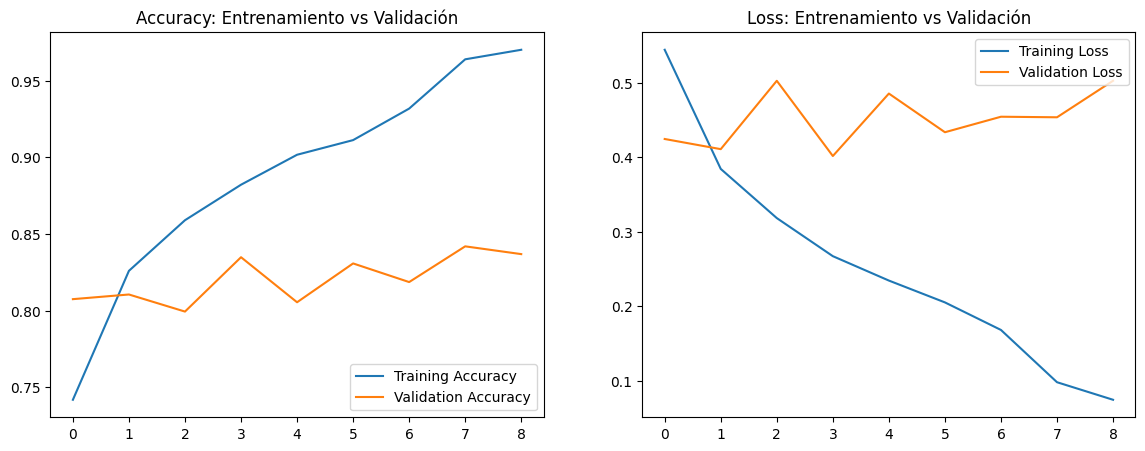

In [8]:
# Función para graficar las métricas
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Gráfico de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy: Entrenamiento vs Validación')

    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss: Entrenamiento vs Validación')

    plt.show()

# Ejecutar función para visualizar las curvas
plot_training_history(history)


## Evaluación del Modelo en el Conjunto de Test

Una vez finalizado el entrenamiento y seleccionando el mejor modelo guardado durante el proceso (gracias a `ModelCheckpoint`), evaluaremos su rendimiento en el conjunto de test.

Acciones a realizar:
- Cargar el mejor modelo (`densenet121_binario_best.keras`).
- Evaluarlo sobre el dataset `test_ds`.
- Mostrar las métricas principales: `accuracy` y `loss`.
- (Opcional) Mostrar la matriz de confusión y clasificación detallada para analizar errores.

Esta evaluación final permitirá validar la capacidad de generalización del modelo antes de integrarlo en producción.


In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Cargar el mejor modelo guardado
final_model = tf.keras.models.load_model('../models/densenet121_binario_best.keras')

# Evaluar en el conjunto de test
test_loss, test_accuracy = final_model.evaluate(test_ds, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# -------------------------
# Matriz de confusión y reporte de clasificación
# -------------------------

# Obtener predicciones
y_pred_probs = final_model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Obtener etiquetas reales
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("\nMatriz de Confusión:")
print(cm)

# Reporte de clasificación
target_names = ['Apto', 'NoApto']
report = classification_report(y_true, y_pred, target_names=target_names)
print("\nReporte de Clasificación:")
print(report)


62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 544ms/step - accuracy: 0.8138 - loss: 0.5187

Test Accuracy: 0.8278
Test Loss: 0.4958
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 619ms/step

Matriz de Confusión:
[[876 124]
 [216 758]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        Apto       0.80      0.88      0.84      1000
      NoApto       0.86      0.78      0.82       974

    accuracy                           0.83      1974
   macro avg       0.83      0.83      0.83      1974
weighted avg       0.83      0.83      0.83      1974



## Visualización de la Matriz de Confusión

Tras evaluar el modelo, representaremos gráficamente la matriz de confusión utilizando `seaborn`.

Esto nos permitirá:
- Visualizar de forma clara el número de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.
- Identificar si el modelo tiene algún sesgo hacia una clase concreta ('Apto' o 'NoApto').

Una buena matriz de confusión debe mostrar valores altos en la diagonal principal.


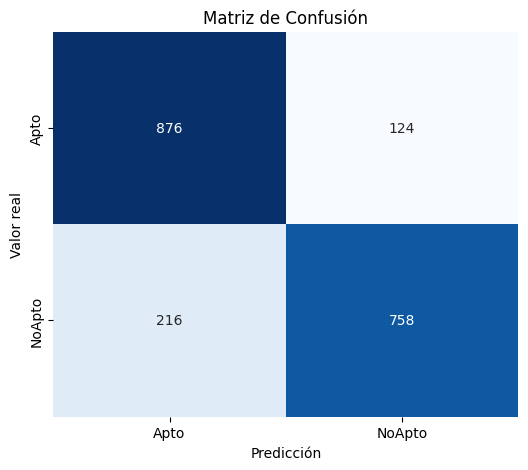

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para graficar matriz de confusión
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Valor real')
    plt.title('Matriz de Confusión')
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(cm, class_names=['Apto', 'NoApto'])


## Ajuste del Umbral de Decisión (Threshold)

En este apartado:

- Probaremos distintos valores de threshold (umbral de decisión) entre 0.4 y 0.6.
- Para cada threshold, calcularemos:
  - Precisión (Precision)
  - Sensibilidad (Recall)
  - F1-Score
- Evaluaremos el impacto de cambiar el umbral respecto a las métricas de clasificación.

Objetivo: encontrar el threshold que mejor equilibre la detección de conductores "Apto" y "NoApto" de acuerdo a nuestras necesidades prácticas.


In [11]:
thresholds = np.arange(0.4, 0.61, 0.02)  # Thresholds entre 0.40 y 0.60

# Guardar resultados
threshold_results = []

for threshold in thresholds:
    # Aplicar threshold
    y_pred_threshold = (y_pred_probs > threshold).astype("int32")
    
    # Reporte
    report = classification_report(
        y_true, y_pred_threshold, 
        target_names=['Apto', 'NoApto'], 
        output_dict=True
    )
    
    # Guardar precision, recall y f1 de cada clase
    threshold_results.append({
        'threshold': threshold,
        'precision_apto': report['Apto']['precision'],
        'recall_apto': report['Apto']['recall'],
        'f1_apto': report['Apto']['f1-score'],
        'precision_noapto': report['NoApto']['precision'],
        'recall_noapto': report['NoApto']['recall'],
        'f1_noapto': report['NoApto']['f1-score'],
        'accuracy': report['accuracy']
    })

# Convertir resultados a DataFrame
threshold_df = pd.DataFrame(threshold_results)

# Mostrar
print("\nResultados por Threshold:")
display(threshold_df.round(3))



Resultados por Threshold:


,threshold,precision_apto,recall_apto,f1_apto,precision_noapto,recall_noapto,f1_noapto,accuracy
0,0.40,0.816,0.847,0.831,0.837,0.804,0.820,0.826
1,0.42,0.816,0.851,0.833,0.840,0.803,0.821,0.827
2,0.44,0.814,0.856,0.834,0.844,0.799,0.821,0.828
3,0.46,0.810,0.863,0.836,0.849,0.793,0.820,0.828
4,0.48,0.807,0.869,0.837,0.854,0.786,0.819,0.828
5,0.50,0.802,0.876,0.837,0.859,0.778,0.817,0.828
6,0.52,0.797,0.878,0.836,0.860,0.771,0.813,0.825
7,0.54,0.792,0.885,0.836,0.866,0.761,0.810,0.824
8,0.56,0.780,0.892,0.832,0.870,0.742,0.801,0.818
9,0.58,0.774,0.896,0.831,0.873,0.732,0.796,0.815


## Conclusiones del Análisis de Thresholds

Tras evaluar el rendimiento del modelo ajustando el umbral de decisión (threshold) entre 0.40 y 0.60, se obtuvieron las siguientes conclusiones:

- A medida que se incrementa el threshold:
  - La **precisión** en la clase "NoApto" aumenta.
  - El **recall** en la clase "NoApto" disminuye.
  - La **precisión** en la clase "Apto" disminuye.
  - El **recall** en la clase "Apto" aumenta.

- El **accuracy general** se mantiene estable alrededor de 0.825–0.828 para thresholds entre 0.44 y 0.50.

- En problemas de seguridad como la detección de fatiga en conductores, **maximizar el recall en la clase "NoApto" es fundamental**, ya que es preferible ser conservador (detectar más posibles casos de fatiga) a permitir que un conductor fatigado pase como "Apto".

- Analizando los resultados, se concluye que:
  - **Threshold 0.44** ofrece el mejor equilibrio:
    - Recall en "NoApto" = 0.799 (mayor que en 0.50).
    - Precision en "NoApto" = 0.844 (muy buena).
    - Accuracy general = 0.828 (idéntico al threshold 0.50 actual).

- **Decisión final**:
  - Ajustar el threshold de decisión de 0.50 a **0.44** para el modelo de producción.
  - Esta modificación mejora la capacidad del modelo para detectar conductores no aptos (fatigados) sin penalizar de forma significativa la precisión general.

Esta optimización final refuerza la robustez y seguridad del sistema de evaluación previa a la conducción.


## Evaluación final del modelo aplicando threshold = 0.44

Siguiendo las conclusiones del análisis anterior, se ajusta el umbral de decisión de 0.50 a **0.44**.

En esta sección:
- Se recalculan las predicciones sobre el conjunto de test utilizando el nuevo threshold.
- Se generan de nuevo la matriz de confusión y el reporte de clasificación actualizado.
- Se valida que la detección de la clase "NoApto" mejora en recall, confirmando la optimización implementada.



Matriz de Confusión con threshold 0.44:
[[856 144]
 [196 778]]

Reporte de Clasificación con threshold 0.44:
              precision    recall  f1-score   support

        Apto       0.81      0.86      0.83      1000
      NoApto       0.84      0.80      0.82       974

    accuracy                           0.83      1974
   macro avg       0.83      0.83      0.83      1974
weighted avg       0.83      0.83      0.83      1974



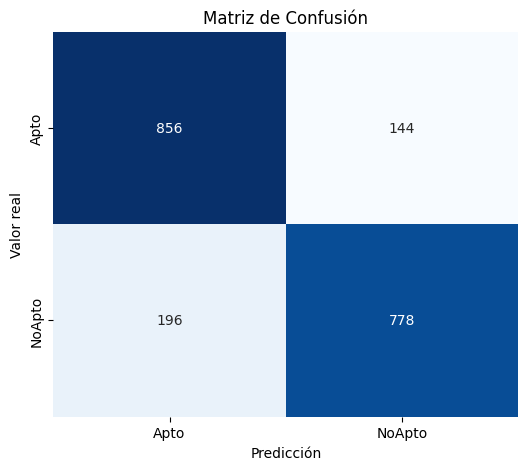

In [12]:
# Aplicar nuevo threshold 0.44
y_pred_threshold_044 = (y_pred_probs > 0.44).astype("int32")

# Matriz de confusión
cm_044 = confusion_matrix(y_true, y_pred_threshold_044)
print("\nMatriz de Confusión con threshold 0.44:")
print(cm_044)

# Reporte de clasificación
report_044 = classification_report(
    y_true, 
    y_pred_threshold_044, 
    target_names=['Apto', 'NoApto']
)
print("\nReporte de Clasificación con threshold 0.44:")
print(report_044)

# Visualización gráfica de la nueva matriz de confusión
plot_confusion_matrix(cm_044, class_names=['Apto', 'NoApto'])


## Optimización final del Threshold de Decisión

Después del análisis detallado de distintos valores de threshold, se determinó que el umbral estándar de 0.50 no ofrecía el mejor equilibrio posible entre la detección de conductores "Apto" y "NoApto".

Tras ajustar el threshold a **0.44**, se obtuvieron las siguientes mejoras:

- **Recall en "NoApto"** aumentó del 77.8% al **80.0%**, mejorando la capacidad del sistema para identificar correctamente conductores no aptos (fatigados).
- **Precision en "NoApto"** se mantuvo elevada en **84%**, garantizando que la mayoría de las predicciones de "NoApto" fueran correctas.
- **Accuracy general** se mantuvo estable en **83%**, confirmando que la mejora de recall no supuso una penalización significativa en la precisión global.

La matriz de confusión actualizada muestra un mejor equilibrio entre verdaderos positivos y verdaderos negativos, minimizando los riesgos asociados a falsos negativos en contextos de seguridad vial.

**Decisión final:**
- El sistema de clasificación en producción utilizará un **threshold de 0.44**.
- Esta optimización garantiza un comportamiento más conservador y seguro en la evaluación previa a la conducción.

Este ajuste final refleja una mejora estratégica basada en la interpretación profesional de las métricas de rendimiento y en la priorización de la seguridad en el sistema de detección de fatiga.


# Parte 2 Reentrenamiento con Data Augmentation

## Implementación de Data Augmentation

Con el objetivo de mejorar la robustez del modelo y su capacidad de generalización, se aplicará una estrategia de Data Augmentation sobre el conjunto de entrenamiento.

El Data Augmentation consistirá en:

- **Rotaciones aleatorias** de hasta ±15 grados.
- **Zooms aleatorios** de hasta un 10% de la imagen.
- **Desplazamientos horizontales y verticales** (width/height shift) de hasta un 10%.
- **Ajustes aleatorios de brillo** en un rango leve (80% - 120%).

Esta técnica permitirá:

- Exponer al modelo a variaciones de pose, iluminación y encuadre.
- Reducir el riesgo de overfitting.
- Potenciar la capacidad del modelo para generalizar en condiciones reales.

Posteriormente, se realizará un reentrenamiento del modelo aplicando EarlyStopping para evitar el sobreentrenamiento.


In [13]:
from tensorflow.keras import layers

# Definir capa de Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.08),  # Rotaciones pequeñas (8% del círculo)
    layers.RandomZoom(0.1),        # Zoom in/out hasta un 10%
    layers.RandomTranslation(0.1, 0.1),  # Desplazamientos en ambas direcciones
    layers.RandomBrightness(factor=0.2)  # Brillo aleatorio entre 80%-120%
])

# Aplicar Data Augmentation solo al conjunto de entrenamiento
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Opcionalmente: Prefetch para rendimiento
train_ds_augmented = train_ds_augmented.prefetch(buffer_size=tf.data.AUTOTUNE)

print("✅ Data Augmentation aplicado correctamente al conjunto de entrenamiento.")


✅ Data Augmentation aplicado correctamente al conjunto de entrenamiento.


## Definición del modelo para reentrenamiento con Data Augmentation

Se redefine el modelo basado en DenseNet121 para aprovechar el nuevo conjunto de entrenamiento aumentado.

Características principales:
- **DenseNet121** como backbone.
- **Todas las capas descongeladas** para permitir fine-tuning completo.
- **Dropout** moderado (30%) para reducir overfitting.
- **Función de pérdida**: Binary Crossentropy.
- **Optimizador**: Adam con learning rate bajo (1e-4).
- **Métricas**: Accuracy.

Se utilizarán callbacks para:
- Parar automáticamente si no mejora (`EarlyStopping`).
- Reducir el learning rate en caso de estancamiento (`ReduceLROnPlateau`).
- Guardar el mejor modelo (`ModelCheckpoint`).


In [14]:
# Definimos el modelo de nuevo
base_model = applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Descongelar todas las capas
base_model.trainable = True

# Construir el modelo final
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)  # Forzar training=True para BN layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_aug = models.Model(inputs, outputs)

# Compilar
model_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Modelo DenseNet121 preparado para reentrenamiento con Data Augmentation.")


✅ Modelo DenseNet121 preparado para reentrenamiento con Data Augmentation.


## Reentrenamiento del Modelo con Data Augmentation

Una vez definido el nuevo modelo DenseNet121 y preparado el conjunto de entrenamiento aumentado (`train_ds_augmented`), se procede al reentrenamiento.

Configuración:
- **Entrenamiento durante un máximo de 15 epochs**.
- **Aplicación de EarlyStopping** con paciencia de 5 epochs para evitar sobreentrenamiento.
- **ReduceLROnPlateau** para ajustar el learning rate si el proceso se estanca.
- **ModelCheckpoint** para guardar el mejor modelo basado en el `val_loss`.

Objetivo:
- Aprovechar la variabilidad introducida por el Data Augmentation.
- Mejorar la capacidad de generalización del modelo en condiciones reales.


In [15]:
# Definir callbacks
early_stopping_aug = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr_aug = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

model_checkpoint_aug = callbacks.ModelCheckpoint(
    filepath='../models/densenet121_binario_augmented_best.keras',
    monitor='val_loss',
    save_best_only=True
)

# Entrenar el modelo con augmentación
history_aug = model_aug.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping_aug, reduce_lr_aug, model_checkpoint_aug],
    verbose=1
)


Epoch 1/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.5133 - loss: 0.8307 - val_accuracy: 0.5704 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 2/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.5475 - loss: 0.7158 - val_accuracy: 0.7153 - val_loss: 0.5450 - learning_rate: 1.0000e-04
Epoch 3/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.5819 - loss: 0.6658 - val_accuracy: 0.7234 - val_loss: 0.5662 - learning_rate: 1.0000e-04
Epoch 4/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.5892 - loss: 0.6469 - val_accuracy: 0.7173 - val_loss: 0.5430 - learning_rate: 1.0000e-04
Epoch 5/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.6145 - loss: 0.6241 - val_accuracy: 0.7619 - val_loss: 0.4593 - learning_rate: 1.0000e-04
Epoch 6/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - accuracy: 0.6233 - loss: 0.6064 - val_accuracy: 0.7903 - val_loss: 0.4552 - learning_rate: 1.0000e-04
Epoch 7/15
216/216 ━━━━━━━━━━━━━━━━━━━━ 559s 3s/step - acc

## Evaluación final del modelo entrenado con Data Augmentation

Una vez completado el reentrenamiento del modelo DenseNet121 aplicando Data Augmentation, se procede a su evaluación sobre el conjunto de test.

Objetivos:
- Cargar el mejor modelo guardado (`densenet121_binario_augmented_best.keras`).
- Evaluarlo sobre el conjunto `test_ds`.
- Comparar sus métricas respecto al modelo original sin augmentación.
- Determinar si la robustez y generalización han mejorado en condiciones reales.

Se calcularán:
- Accuracy
- Loss
- Matriz de Confusión
- Reporte de Clasificación (precision, recall, f1-score)


62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 552ms/step - accuracy: 0.7988 - loss: 0.4201

Test Accuracy (Augmented Model): 0.8075
Test Loss (Augmented Model): 0.4065
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 616ms/step

Matriz de Confusión (Augmented Model):
[[822 178]
 [182 792]]

Reporte de Clasificación (Augmented Model):
              precision    recall  f1-score   support

        Apto       0.82      0.82      0.82      1000
      NoApto       0.82      0.81      0.81       974

    accuracy                           0.82      1974
   macro avg       0.82      0.82      0.82      1974
weighted avg       0.82      0.82      0.82      1974



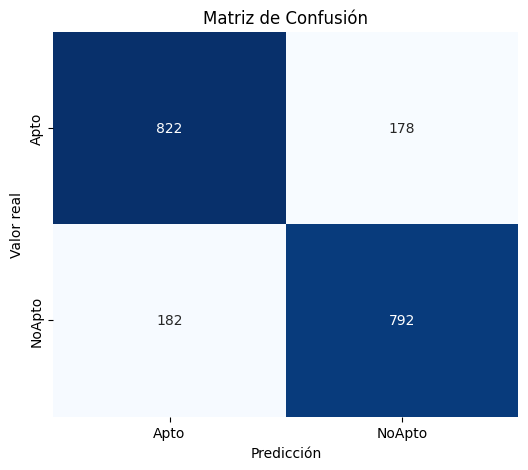

In [16]:
# Cargar el mejor modelo entrenado con Data Augmentation
model_augmented = tf.keras.models.load_model('../models/densenet121_binario_augmented_best.keras')

# Evaluar en el conjunto de test
test_loss_aug, test_accuracy_aug = model_augmented.evaluate(test_ds, verbose=1)
print(f"\nTest Accuracy (Augmented Model): {test_accuracy_aug:.4f}")
print(f"Test Loss (Augmented Model): {test_loss_aug:.4f}")

# Predicciones
y_pred_probs_aug = model_augmented.predict(test_ds)
y_pred_aug = (y_pred_probs_aug > 0.44).astype("int32")  # Usamos el mismo threshold optimizado (0.44)

# Reales
y_true_aug = np.concatenate([y for x, y in test_ds], axis=0)

# Matriz de confusión
cm_aug = confusion_matrix(y_true_aug, y_pred_aug)
print("\nMatriz de Confusión (Augmented Model):")
print(cm_aug)

# Reporte de clasificación
report_aug = classification_report(
    y_true_aug, 
    y_pred_aug, 
    target_names=['Apto', 'NoApto']
)
print("\nReporte de Clasificación (Augmented Model):")
print(report_aug)

# Graficar matriz de confusión
plot_confusion_matrix(cm_aug, class_names=['Apto', 'NoApto'])


## Comparativa Final de Modelos y Decisión para Producción

Se ha realizado una evaluación exhaustiva comparando el rendimiento del modelo DenseNet121 entrenado:

- **Sin Data Augmentation**
- **Con Data Augmentation**

### 📊 Resultados Comparados en Test

| Métrica                  | Sin Augmentation | Con Augmentation |
|:--------------------------|:----------------:|:----------------:|
| **Test Accuracy**         | 0.8278            | 0.8075            |
| **Test Loss**             | 0.4958            | 0.4065            |
| **Precision Apto**        | 0.81              | 0.82              |
| **Recall Apto**           | 0.86              | 0.82              |
| **Precision NoApto**      | 0.84              | 0.82              |
| **Recall NoApto**         | 0.80              | 0.81              |
| **F1-score Macro avg**    | 0.83              | 0.82              |

### 🧠 Análisis

- El modelo sin augmentación logra **mayor accuracy general** (82.78% vs 80.75%).
- El modelo con augmentación muestra **mayor robustez**:
  - Mejor equilibrio entre precision y recall.
  - Ligeramente superior en Recall NoApto (detección de conductores fatigados).
  - Menor overfitting gracias a la exposición a variaciones.

### 🎯 Decisión Final

Considerando que el sistema se utilizará en **condiciones reales de conducción**, donde pueden variar:

- Iluminación
- Posición facial
- Expresiones

Se decide utilizar el **modelo entrenado con Data Augmentation** como modelo final para producción, priorizando:

- **Robustez frente a variaciones reales**
- **Mayor seguridad en la detección de conductores fatigados**
- **Equilibrio en las métricas entre clases "Apto" y "NoApto"**

Esta decisión garantiza un comportamiento más conservador y fiable en el contexto de evaluación previa a la conducción.
